In [1]:
from google.colab import drive
import zipfile
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization



In [2]:
# Mount Google Drive ke Colab
!pip install -q kaggle


In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"baguspurnomo","key":"2662f816ae27c48365145b088b475dfb"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
 ! kaggle datasets list

ref                                                                   title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
shreyanshverma27/online-sales-dataset-popular-marketplace-data        Online Sales Dataset - Popular Marketplace Data     7KB  2024-05-25 23:55:26           6182        118  1.0              
rabieelkharoua/cancer-prediction-dataset                              🩺📊 Cancer Prediction Dataset 🌟🔬                    47KB  2024-06-10 03:54:18           1276         28  1.0              
mexwell/pizza-sales                                                   🍕 Pizza Sales                                     586KB  2024-06-06 07:18:22           1552         29  1.0              
informrohit1/smartphones-dataset        

In [8]:
!kaggle datasets download -d niten19/face-shape-dataset

Dataset URL: https://www.kaggle.com/datasets/niten19/face-shape-dataset
License(s): CC0-1.0
 99% 633M/639M [00:03<00:00, 173MB/s]
100% 639M/639M [00:03<00:00, 178MB/s]


In [9]:
print(f"On device: {tf.test.gpu_device_name() if tf.test.is_gpu_available() else 'CPU'}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


On device: /device:GPU:0


In [10]:
! mkdir face-shape-dataset

In [11]:
! unzip face-shape-dataset.zip -d face-shape-dataset/

Streaming output truncated to the last 5000 lines.
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (123).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (13).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (135).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (136).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (137).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (138).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (139).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (140).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (141).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (156).jpg  
  inflating: face-shape-dataset/FaceShape Dataset/testing_set/Heart/heart (161).jpg  
  in

In [12]:

# Path ke folder dataset
train_data_dir = 'face-shape-dataset/FaceShape Dataset/training_set'
test_data_dir = 'face-shape-dataset/FaceShape Dataset/testing_set'


In [13]:
file_to_delete = '/content/face-shape-dataset/FaceShape Dataset/training_set/Square/square (84).jpg'

if os.path.exists(file_to_delete):
    os.remove(file_to_delete)
    print(f"{file_to_delete} has been deleted.")
else:
    print(f"{file_to_delete} does not exist.")

/content/face-shape-dataset/FaceShape Dataset/training_set/Square/square (84).jpg has been deleted.


In [14]:
file_to_delete = '/content/face-shape-dataset/FaceShape Dataset/training_set/Heart/heart (633).jpg'

if os.path.exists(file_to_delete):
    os.remove(file_to_delete)
    print(f"{file_to_delete} has been deleted.")
else:
    print(f"{file_to_delete} does not exist.")

/content/face-shape-dataset/FaceShape Dataset/training_set/Heart/heart (633).jpg has been deleted.


In [15]:
class MyCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if 'accuracy' in logs and 'val_accuracy' in logs:
            if logs['accuracy'] > 0.9 and logs['val_accuracy'] > 0.9:  # Ubah 'accuracy' sesuai dengan metrik yang Anda gunakan
                print("\nAkurasi telah mencapai di atas 90%, menghentikan pelatihan.")
                self.model.stop_training = True


In [16]:

# Parameter untuk pengolahan gambar
img_width, img_height = 224, 224
batch_size = 16

# Augmentasi dan normalisasi data pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Normalisasi data pengujian (tanpa flipping horizontal)
test_datagen = ImageDataGenerator(rescale=1./255)

# Muat data pelatihan
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Muat data pengujian
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Menggunakan model pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Membekukan semua lapisan VGG16
for layer in base_model.layers:
    layer.trainable = False

# Bangun model CNN di atas VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

# Callback untuk menghentikan pelatihan lebih awal jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Kompilasi model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Pelatihan model
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Membuka beberapa lapisan terakhir dari VGG16 untuk fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True



Found 3998 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/60
250/250 [==============================] - 103s 351ms/step - loss: 2.5682 - accuracy: 0.3034 - val_loss: 2.0878 - val_accuracy: 0.3580 - lr: 1.0000e-04
Epoch 2/60
250/250 [==============================] - 82s 329ms/step - loss: 2.1846 - accuracy: 0.3674 - val_loss: 1.8832 - val_accuracy: 0.4360 - lr: 1.0000e-04
Epoch 3/60
250/250 [==============================] - 82s 330ms/step - loss: 2.0656 - accuracy: 0.4015 - val_loss: 1.7496 - val_accuracy: 0.4580 - lr: 1.0000e-04
Epoch 4/60
250/250 [==============================] - 83s 331ms/step - loss: 1.9491 - accuracy: 0.4175 - val_loss: 1.7665 - val_accuracy: 0.4480 - lr: 1.0000e-04
Epoch 5/60
250/250 [==============================] - 85s 342ms/step - loss: 1.8256 - accuracy: 0.4625 - val_loss: 1.7726 - val_accuracy: 0.4550 - lr: 1.0000e-04
Epoch 6/60
250/250 [====================

In [17]:
# Kompilasi ulang model dengan learning rate yang sangat rendah
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Pelatihan lanjutan (fine-tuning)
history_fine = model.fit(

    train_generator,
    epochs=40,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluasi model
evaluation = model.evaluate(test_generator)
print(f"Loss: {evaluation[0]}, Accuracy: {evaluation[1]}")

# Menyimpan model
model.save('/content/save_model.h5')

Epoch 1/40
250/250 [==============================] - 86s 331ms/step - loss: 0.9734 - accuracy: 0.7229 - val_loss: 1.5065 - val_accuracy: 0.5610 - lr: 1.0000e-05
Epoch 2/40
250/250 [==============================] - 82s 326ms/step - loss: 0.9151 - accuracy: 0.7391 - val_loss: 1.4387 - val_accuracy: 0.5730 - lr: 1.0000e-05
Epoch 3/40
250/250 [==============================] - 83s 331ms/step - loss: 0.8787 - accuracy: 0.7569 - val_loss: 1.5015 - val_accuracy: 0.5640 - lr: 1.0000e-05
Epoch 4/40
250/250 [==============================] - 83s 331ms/step - loss: 0.8189 - accuracy: 0.7781 - val_loss: 1.4687 - val_accuracy: 0.5850 - lr: 1.0000e-05
Epoch 5/40
250/250 [==============================] - 84s 336ms/step - loss: 0.7958 - accuracy: 0.7924 - val_loss: 1.4369 - val_accuracy: 0.5840 - lr: 1.0000e-05
Epoch 6/40
250/250 [==============================] - 83s 334ms/step - loss: 0.7548 - accuracy: 0.8067 - val_loss: 1.4230 - val_accuracy: 0.5740 - lr: 1.0000e-05
Epoch 7/40
250/250 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


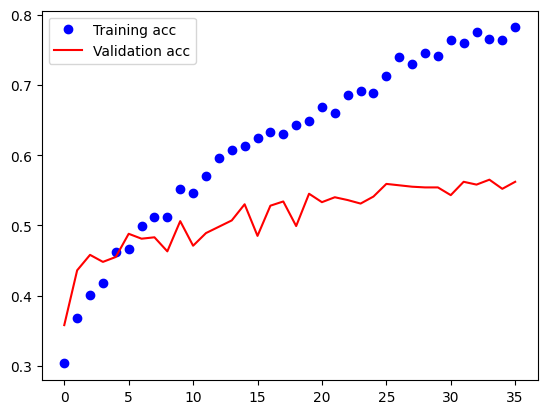

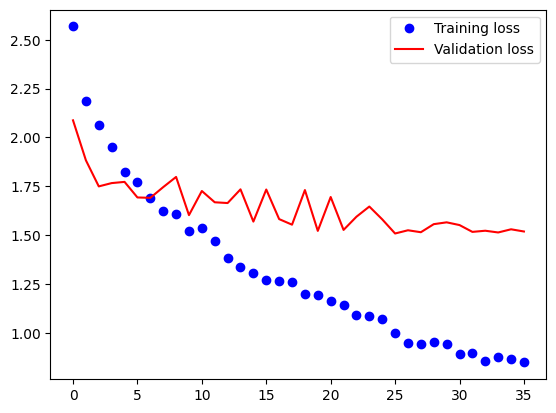

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt


epochs = range(len(acc))
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.legend()


plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')

plt.legend()
plt.show()

In [19]:
import requests

url = '/content/save_model.h5'
output = 'save_model.h5'

response = requests.get(url)
with open(output, 'wb') as file:
    file.write(response.content)

print(f"Model berhasil didownload dan disimpan sebagai {output}")


MissingSchema: Invalid URL '/content/save_model.h5': No scheme supplied. Perhaps you meant https:///content/save_model.h5?

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil prediksi pada set pengujian
Y_pred = model.predict(test_generator, test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Ambil label asli dari set pengujian
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Buat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:

# Simpan model
model.save('/content/drive/MyDrive/Face Shape/model_faceshape.h5')


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Face Shape/model_faceshape.h5')

In [ ]:
# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


In [ ]:
with open('FaceShape.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Face Shape/model_facesahpe.h5')

# Convert the model to TensorFlow Lite format with NormalizationOptions
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
input_mean = 0.0  # Update with your mean value
input_std = 1.0  # Update with your std value
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.target_spec.supported_types = [tf.float32]
converter.representative_dataset = tf.lite.RepresentativeDataset(
    lambda: generator_for_calibration())
converter.normalization_mean = input_mean
converter.normalization_std = input_std

# Convert the model
tflite_model = converter.convert()

# Save the converted model
with open('FaceShape1.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

# 1. Simpan model yang telah dilatih
# Asumsi model sudah dilatih sebelumnya dan disimpan
# model.save('my_trained_model.h5')

# 2. Muat model yang telah disimpan
model = tf.keras.models.load_model('/content/drive/MyDrive/Face Shape/model_facesahpe.h5')

# 3. Preproses gambar manual
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((150, 150))  # Resize to 28x28 pixels
    img = np.array(img)  # Convert to numpy array
    img = img / 255.0  # Normalize to [0, 1]
    img = img.reshape(1, 150, 150, 1)  # Reshape to (1, 28, 28, 1) for model input
    return img

# Path ke gambar manual yang ingin diuji
image_path = files.upload()

# Muat dan preproses gambar
input_image = load_and_preprocess_image(image_path)

# 4. Gunakan model untuk membuat prediksi pada gambar yang telah dipreproses
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)

# 5. Tampilkan hasil prediksi
print(f'Predicted class: {predicted_class}')

# Visualisasi gambar input
plt.imshow(input_image[0, :, :, 0], cmap='gray')
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


In [ ]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size =(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Face Shape/cancer_classification.tflite")
interpreter.allocate_tensors()

In [ ]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get metadata
with open("metadata.json", 'r') as f:
    metadata = json.load(f)